In [2]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Instructions
To run this notebook, you will need to download the Brainspan "Developmental Transcriptome Dataset", which can be found here: https://www.brainspan.org/static/download.html

Note where you save this data. May be simplest to put it in the ./data directory.



# Load brainspan data

I need to come back here and add the things I did to make these notebooks

In [3]:
# Where to save figures
fig_dir = './figures/'
bspan_dir = './data/'

In [5]:
df = pandas.read_csv(os.path.join(bspan_dir,'gene_expression_original.csv',)) # expression data
rmd = pandas.read_csv(os.path.join(bspan_dir,'gene_metadata_original.csv')) # rows metadata
cmd = pandas.read_csv(os.path.join(bspan_dir,'samples_metadata.csv')) # columns metadata

In [13]:
len(rmd.gene_symbol.unique())

47808

#### address duplicates

In [14]:
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

It appears most uniques are RNA or things we dont care about. I will remove them

In [9]:
df.shape

(52376, 525)

In [10]:
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
df.drop(bad_index,inplace=True)

# Harmonize datasets

#### Load component data

In [4]:
# We created this notebook in NB3_PLS_ModelExploration
all_comps = pandas.read_csv('./data/all_comps.csv',index_col=0)

#### harmonize genes

In [7]:
shared = list(set(rmd.gene_symbol.values) & set(all_comps.gene_symbol))
len(shared)

13786

In [8]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13854, 525)

In [9]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,0.260205,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879


#### Get gene expression for each component and each columns

In [10]:
gdf = pandas.DataFrame(cmd,copy=True)

In [23]:
n_comps = 3

In [27]:
all_comps.index = all_comps.gene_symbol.values
for i,col in enumerate(gxp.columns):
    for c in range(1,(n_comps+1)):
        gdf.loc[i,'C%s_exp'%c] = np.dot(gxp[col],all_comps.loc[gxp.index,'C%s'%c].values)
    
    

In [17]:
## if you want to save the harmonized dataset, uncomment below
# gdf.to_csv('data/GCorr_Brainspan.csv')

In [11]:
## if you want to load your saved harmonized dataset, uncomment below
#gdf = pandas.read_csv('data/GCorr_Brainspan.csv')

#### Prepare stuff for plots

In [12]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs',]
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


In [13]:
# brain divisions

Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [14]:
# get log age
# deal with the nine months before birth before logging...
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [15]:
# same thing for weeks
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [16]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [17]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

# Plot component dispersion across brainspan

First we'll just look at regions at one side or the other of each gradient, to see how expression of the component in these regions changes over the lifespan

Text(0.5, 15.439999999999998, 'log age (weeks)')

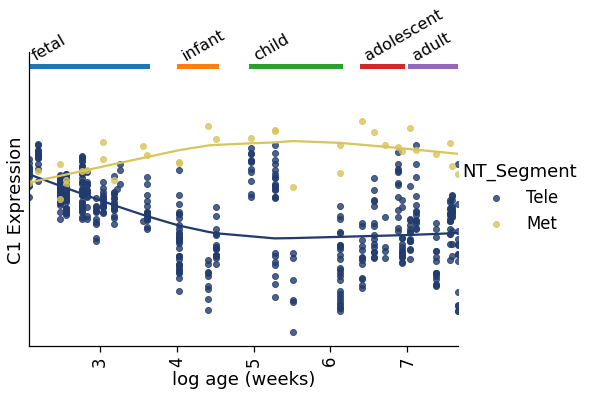

In [39]:
# C1

# plot
rbpal = [sns.color_palette('cividis')[-1],
                      sns.color_palette('cividis')[0]]
g = sns.lmplot(x='log_age_weeks',y='C1_exp',aspect=1.5,
               data=gdf,
               #[gdf['C1_exp']<1000],
           hue='NT_Segment',lowess=True,
              palette=rbpal[::-1])
g.set_xticklabels(rotation=90)

# decorate to show age stage in dataset 
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[100,100],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,110,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C1 Expression')
plt.yticks([])
plt.xlabel('log age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BS_Devel_C1.pdf'),bbox_inches='tight')

Text(0.5, 15.439999999999998, 'log age (weeks)')

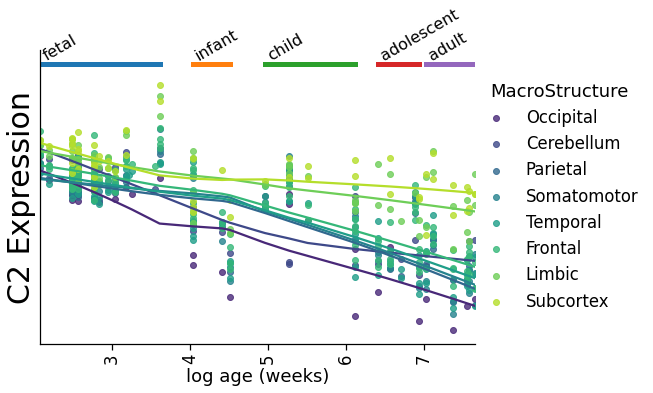

In [40]:
# C2
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='log_age_weeks',y='C2_exp',aspect=1.5,
               data=gdf[(gdf.MacroStructure!='GangEm') &\
                        (gdf['C2_exp']<1000)],
           hue='MacroStructure',lowess=True,
               hue_order=['Occipital','Cerebellum','Parietal','Somatomotor',
                          'Temporal','Frontal','Limbic','Subcortex'],
              palette='viridis')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[500,500],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,500,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('log age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BS_Devel_C2.pdf'),bbox_inches='tight')

Text(0.5, 15.439999999999998, 'log age (weeks)')

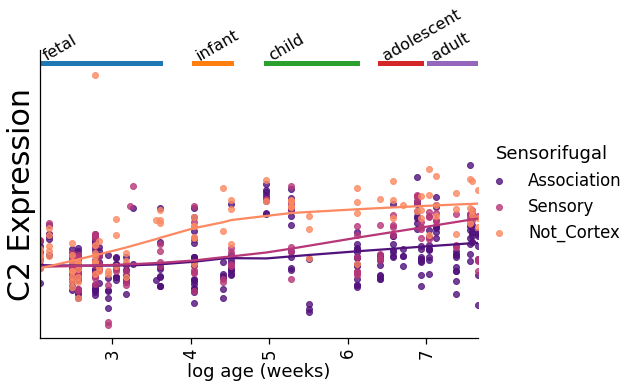

In [44]:
# c3
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='log_age_weeks',y='C3_exp',aspect=1.5,
               data=gdf[gdf.C3_exp<400],
           hue='Sensorifugal',lowess=True,
              palette='magma')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[400,400],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,400,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('log age (weeks)')

#plt.savefig(os.path.join(fig_dir,'BS_Devel_C3.pdf'),bbox_inches='tight')

# Comparison to adult

In NB3_PLS_ModelExploration, we generated component expression for Allen Brain Atlas data reduced to a low resolution (so as to better match the brainspan resolution). Here, we will load this data to compare regional expression of each component across the two datasets

#### Initialize some stuff

In [18]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure2.unique()))
print('missing:',set(gdf.MacroStructure2.unique()) - set(abac2.index))

shared: {'Parietal', 'Occipital', 'Sensorimotor', 'Cerebellum', 'Frontal', 'Thalamus', 'Temporal', 'Striatum', 'Limbic'}
missing: {'GangEm'}


In [19]:
bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

In [20]:
c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,54.009712,22.478217,-0.245697,0.002831,Cerebellum
Frontal,88.577454,10.517804,-0.139174,0.004629,Frontal
Limbic,160.740812,11.764159,0.091255,0.008090,Limbic
Occipital,15.538342,25.910240,-0.399042,0.006815,Occipital
Parietal,46.692832,22.004353,-0.307387,0.005913,Parietal


#### Do cross-dataset comparison

In [24]:
# z-score data to account for standardized vs. non-standardize nature of the two datasets
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(gdf.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    gdf.loc[:,'zC%s_exp'%i,] = vals

r = 0.929, p = 0.0


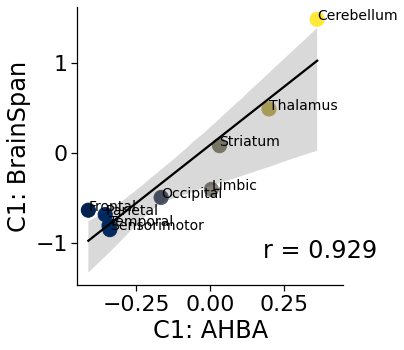

r = 0.973, p = 0.0


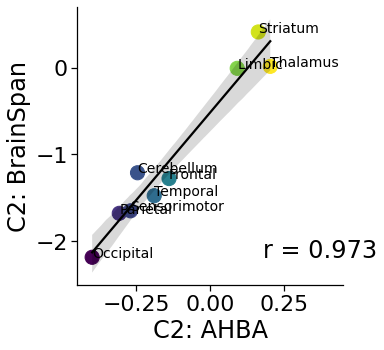

r = 0.858, p = 0.003


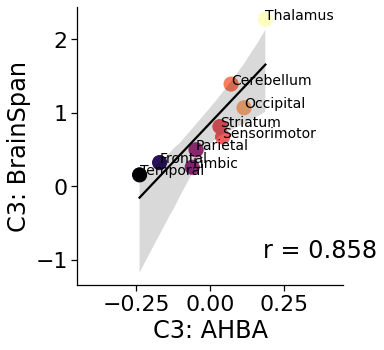

In [25]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Age_Stage=='adult'],# just the adults!
                          values='zC%s_exp'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['zC%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.BS_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'BS_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: BrainSpan'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    plt.xlim(-.45,.45)
    #plt.savefig(os.path.join(fig_dir,'BrSp_Repl_C%s.pdf'%i), bbox_inches='tight')
    plt.show()

# Individual subject matching

We can do the same analysis above, except this time, we can compare regional component expression of individual subjects to those of Allen Brain Atlas. That way, we can track how individual variables (like age) related to how well the components replicate.

In [26]:
# create individual dfs for each component
gpdfs = {}
for i in range(1,(n_comps+1)):
    gpdf = gdf[['donor_id','C%s_exp'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='C%s_exp'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [27]:
# example. We see there is missing data for different donors
print(gpdfs[1].shape)
gpdfs[1].head()

(42, 10)


MacroStructure2,Cerebellum,Frontal,Limbic,Occipital,Parietal,Sensorimotor,Striatum,Temporal,Thalamus,n_valid
donor_id,,,,,,,,,,
12287,NaN,-549.054397,NaN,-498.024254,-459.944829,NaN,-387.944212,-481.506260,-497.448230,6.0
12288,-398.392096,-494.033123,-442.070728,-448.788302,-526.603434,-522.773744,-459.199135,-516.185749,-589.498813,9.0
12289,-141.654528,-773.855294,-673.694021,-600.055663,-700.106295,-737.715407,NaN,-788.517130,NaN,7.0
12290,-284.668462,-783.260437,-688.918239,-707.930881,-859.473773,-807.731521,-584.227903,-820.319401,-609.502898,9.0
12295,-248.567471,-576.861598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [28]:
# how many people are missing how much data?
gpdfs[1].n_valid.value_counts()

9.0    18
8.0     9
7.0     6
6.0     3
4.0     2
2.0     2
3.0     1
1.0     1
Name: n_valid, dtype: int64

In [29]:
# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions

# for each component
for c in range(1,(n_comps+1)):
    # prep data
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [30]:
# build a summary dataframe at the indexed by subjects

cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values
for c in range(1,(n_comps+1)):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

r=0.755, p=0.0


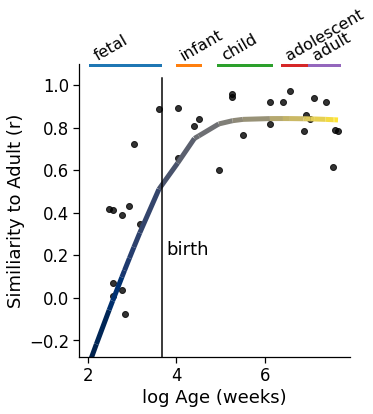

r=0.204, p=0.2338


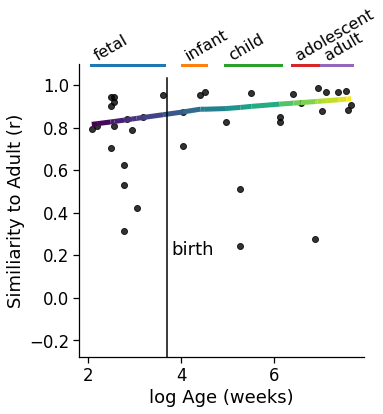

r=0.753, p=0.0


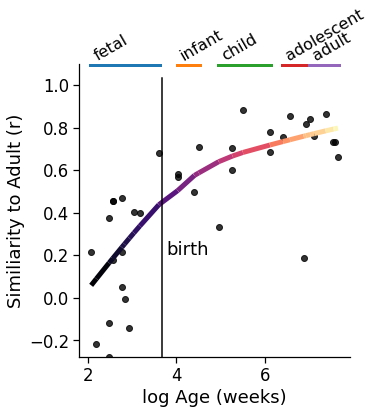

In [31]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 

sns.set_context('notebook',font_scale=1.5)
# for each component
for c in range(1,(n_comps+1)):
    # plot
    g=sns.lmplot(x='log_age_weeks',y='C%s_r'%c,
                lowess=True,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'age_level']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
    # make line purty
    x, y = g.ax.get_lines()[0].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    g.ax.get_lines()[0].remove()
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
    
    # decorate so age stage is indicated
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.28,1.1)
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.axvline(np.log(40),ymax=0.95,c='k')
    plt.text(np.log(40)+0.1,0.2,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    



In [32]:
# Let's plot all those lines on one plot
devplot = pandas.DataFrame(pandas.concat([subsum.C1_r,
                                          subsum.C2_r,
                                          subsum.C3_r]))
devplot.columns = ['r']
n = len(subsum)
devplot.loc[:,'Component'] = ['1']*n + ['2']*n + ['3']*n
devplot.loc[:,'age_level'] = subsum.age_level.tolist() * 3
devplot.loc[:,'age_stage'] = subsum.Age_Stage.tolist() * 3
devplot.loc[:,'age_in_months'] = subsum.age_in_months.tolist() * 3
devplot.loc[:,'log_age_months'] = subsum.log_age_months.tolist() * 3
devplot.loc[:,'age_in_weeks'] = subsum.age_in_weeks.tolist() * 3
devplot.loc[:,'log_age_weeks'] = subsum.log_age_weeks.tolist() * 3

Text(0.5, 15.439999999999998, 'log Age (weeks)')

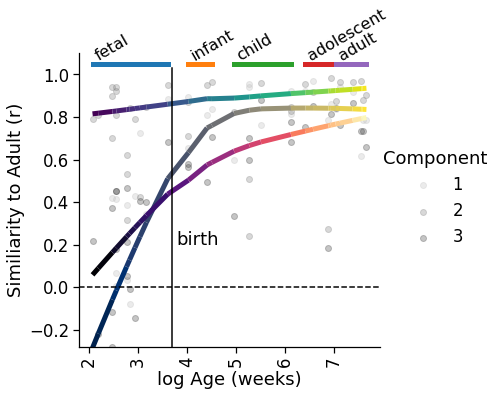

In [33]:
g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
             hue_order=['1','2','3'],palette='binary',
               data=devplot,scatter_kws={'alpha':0.3})
g.ax.set_ylim(-0.3,1.08)
g.set_xticklabels(rotation=90)
for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.2,'birth')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BrSp_CompR_overlay.pdf'),bbox_inches='tight')

# Save progress
(for other notebooks)

In [34]:
gdf.to_csv('data/brainspan.csv')

# Comparison to GTex
Note: The GTEx_Workup notebook should be run before proceeding to this part

In [35]:
# load GTEx derivatives from GTEx_Workup.ipynb notebook
gss = pandas.read_csv('data/GTEx_IndivCongruence.csv',index_col=0)

In [38]:
# Need to re-establish excluded subjects, as we did before in the GTEx notebook
basedf = pandas.read_csv('data/GTEx_brain_norm_noregress_meta.csv')
excludf = pandas.read_csv('data/GTEx_healthy.csv',index_col=0)
excludf.loc[:,'Healthy'] = [x.replace('.','-') for x in excludf.Healthy.values]
dx_exclude = list(set(basedf.SUBJID.values) - set(excludf.Healthy.values))
gss.loc[gss.SUBJID.isin(dx_exclude),'Excl_Dx'] = 1
gss.loc[gss.Excl_Dx!=1,'Excl_Dx'] = 0

In [39]:
# Merge the Brainspan and GTEx dataframes
d1 = pandas.DataFrame(gss[['AGE','SEX','C1_r','C2_r','C3_r','n_valid','Excl_Dx']],
                      copy=True)
d1.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid','Excl_Dx']
d1.loc[:,'cohort'] = 'GTEx'
d1.loc[:,'age_in_months'] = (d1.loc[:,'age'] * 12)+9
d1.loc[:,'age_in_weeks'] = (d1.loc[:,'age'] * 52)+40

d2 = pandas.DataFrame(subsum[['age','gender','C1_r','C2_r',
                              'C3_r','n_valid','age_in_months','age_in_weeks']],
                     copy=True)
d2.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid','age_in_months','age_in_weeks']
d2.loc[:,'cohort'] = 'BrainSpan'

dsmerge = pandas.concat([d1,d2])

In [40]:
# calculate log age and reset index
dsmerge.loc[:,'logAge'] = np.log(dsmerge.loc[:,'age_in_weeks'].values)
dsmerge.loc[:,'old_ind'] = dsmerge.index
dsmerge.index = range(len(dsmerge))

In [42]:
gxp.shape

(13854, 524)

In [43]:
# calculate decade
for i,row in dsmerge.iterrows():
    age = row['age_in_months'] / 12
    if age < 0.72:
        decade = 0
    elif age < 2:
        decade = 0.1
    elif age < 9:
        decade = 0.5
    else:
        decade = round(age/10)
    dsmerge.loc[i,'decade'] = decade

In [44]:
# put together plotting spreadsheets
ages = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].logAge.tolist() * 3)
rs = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].C1_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C2_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C3_r.tolist())
n = len(dsmerge[dsmerge.cohort=='GTEx'])
comp = pandas.Series(['C1']*n + ['C2']*n + ['C3']*n)
decade = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].decade.tolist() * 3)
excl = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].Excl_Dx.tolist() * 3)
gtplotr = pandas.concat([ages,rs,comp,decade,excl],axis=1)
gtplotr.columns = ['logAge','r','component','decade','excl_dx']


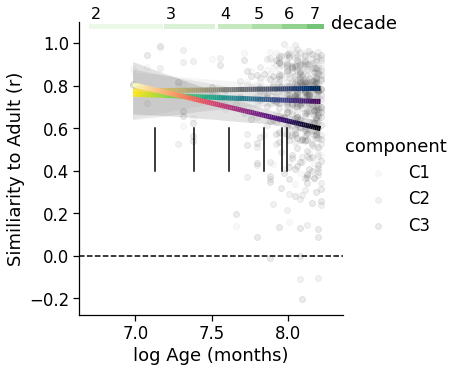

In [46]:
# Make the GTEx plots
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
g=sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr,
          scatter_kws={'alpha':0.1},palette='binary')
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')

for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap='%s_r'%pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax+0.5,1.05,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
#plt.savefig(os.path.join(fig_dir,'GTEx_logAge.pdf'),bbox_inches='tight')

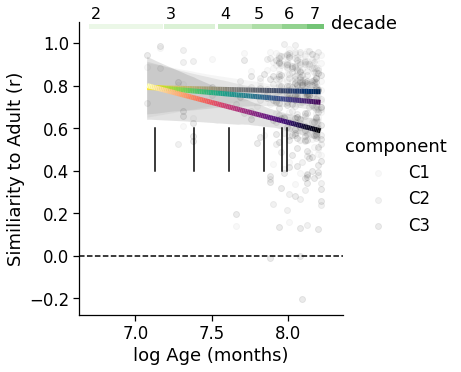

In [47]:
# now repeat after excluding all people who died with a brain-related clinical diagnosis
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
g=sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr[gtplotr.excl_dx==0],
          scatter_kws={'alpha':0.1},palette='binary')
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')

for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap='%s_r'%pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax+0.5,1.05,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
#plt.savefig(os.path.join(fig_dir,'GTEx_logAge_ctrl.pdf'),bbox_inches='tight')

In [63]:
dsmerge.to_csv('BrainSpan_GTEx_PLSC_similarity.csv')